# Feature selection and stability assessment with embedded methods

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from tqdm import tqdm
from stability import getStability

## Load the data

We will load the data that we preprocessed in the data_preprocessing.ipynb notebook. 

In [24]:
data = pd.read_csv("./data/tomatos_with_targets.txt", index_col=0)
data.head()

,Solyc02g081130.1.1,Solyc12g038200.1.1,Solyc00g097760.1.1,Solyc08g069180.2.1,Solyc01g012570.1.1,Solyc08g076670.2.1,Solyc04g024840.2.1,Solyc09g074310.2.1,Solyc09g005370.1.1,Solyc12g098180.1.1,...,Solyc01g088670.1.1,Solyc06g063380.1.1,Solyc10g050450.1.1,Solyc07g051990.1.1,Solyc02g093490.2.1,Solyc10g007270.2.1,species,position,tissue,root
penn.Sh.floral,1.169216,0.000000,0.0,1.305753,0.0,4.634343,2.860965,3.242561,0.0,0.0,...,2.120579,0.0,0.000000,0.0,5.027894,0.0,penn,Sh,floral,0
penn.Sh.leaf,0.000000,0.858644,0.0,2.948383,0.0,4.653912,2.241161,2.922573,0.0,0.0,...,1.370140,0.0,2.006256,0.0,5.068390,0.0,penn,Sh,leaf,0
penn.Sh.root,0.000000,0.000000,0.0,0.469958,0.0,5.798938,3.217704,2.229663,0.0,0.0,...,1.970763,0.0,1.688588,0.0,4.889667,0.0,penn,Sh,root,1
penn.Sh.sdling,1.813992,0.000000,0.0,2.586147,0.0,4.771861,3.099842,3.452604,0.0,0.0,...,1.982446,0.0,1.651062,0.0,3.105620,0.0,penn,Sh,sdling,0
penn.Sh.stem,0.000000,0.000000,0.0,1.540887,0.0,4.907770,4.800873,1.973890,0.0,0.0,...,1.452937,0.0,0.000000,0.0,4.993720,0.0,penn,Sh,stem,0


## Setup

Since there are multiple potential targets, we decide on one and remove the rest

**TODO: this might be removed after we are sure which one to use :)**

In [25]:
# Choose the target
target = 'species'

# Targets
potential_targets = ['species','position','tissue','root']
# Remove other potential targets
drop = list(set(potential_targets) - set([target]))
data_model = data.drop(columns = drop, axis = 1)
data_model.head()

# Save only feature column names:
feature_columns =  data_model.drop(columns=[target], axis=1).columns

We have to make sure we don't have an imbalance problem with the chosen target:

In [26]:
np.unique(data_model[target], return_counts=True)

(array(['M82', 'penn'], dtype=object), array([12, 12]))

Choose the model:

In [27]:
# Set the model
# model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=0.7)
# model_name = 'lasso'
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C=0.5)
model_name = 'elasticnet'

Train-test split, encoding the labels and scaling the data:

In [28]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    data_model.drop(columns=[target], axis=1),
    data_model[target], stratify = data_model[target],
    test_size=0.2,
    random_state=444)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(19, 28298) (5, 28298)
(19,) (5,)
(array(['M82', 'penn'], dtype=object), array([10,  9]))
(array(['M82', 'penn'], dtype=object), array([2, 3]))


Encoding the labels:

In [29]:
# Encode labels if needed
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([10,  9]))
(array([0, 1]), array([2, 3]))


Regression methods benefit from scaled data:

In [30]:
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

## Fit the model and check the selected features

We can use sklearn's function SelectFromModel which...TBA...

In [31]:
selector = SelectFromModel(estimator=model).fit(X_train_transformed, y_train)
general_threshold = selector.threshold_ # It sets it to 1e-05 for the lasso, we can change that. 
general_threshold

/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.0001131053172252306

In [32]:
features_coeff_fullmodel = {}
count = 0
for feature, selected, importance in zip(list(feature_columns), list(selector.get_support()), list(selector.estimator_.coef_[0])):
    features_coeff_fullmodel[feature] = (importance, selected)
    if selected == True:
        count += 1

print(f"There are {count} selected features. Showing features sorted by absolute value of the coefficient:")
sorted(features_coeff_fullmodel.items(), key=lambda x: abs(x[1][0]), reverse=True)

There are 2413 selected features. Showing features sorted by absolute value of the coefficient:


[('Solyc06g048530.2.1', (0.0039665528878362845, True)),
 ('Solyc10g086770.1.1', (0.003937534823378454, True)),
 ('Solyc03g079970.1.1', (0.0039165001479728396, True)),
 ('Solyc04g039670.2.1', (0.003906634562318692, True)),
 ('Solyc07g032080.2.1', (0.0039059897825401346, True)),
 ('Solyc12g042240.1.1', (0.0039017752351434634, True)),
 ('Solyc12g062670.1.1', (0.003891932578881207, True)),
 ('Solyc05g050590.2.1', (0.0038892373594293667, True)),
 ('Solyc06g017860.1.1', (0.0038823902120560007, True)),
 ('Solyc06g036630.1.1', (0.003873941963760991, True)),
 ('Solyc12g088180.1.1', (0.003867865950992952, True)),
 ('Solyc04g055060.1.1', (-0.0038636407884327846, True)),
 ('Solyc12g049580.1.1', (-0.0038632829623538173, True)),
 ('Solyc08g065490.2.1', (-0.0038570386872608955, True)),
 ('Solyc06g036620.1.1', (0.0038482550946588494, True)),
 ('Solyc05g013260.1.1', (0.0038474753915310658, True)),
 ('Solyc10g005120.1.1', (0.00384566466624383, True)),
 ('Solyc11g008420.1.1', (0.0038339215870181434, True

In [33]:
features_coeff_fullmodel = pd.DataFrame(features_coeff_fullmodel).T.reset_index()
features_coeff_fullmodel.columns = ['feature', 'coeff', 'chosen']
features_coeff_fullmodel

,feature,coeff,chosen
0,Solyc02g081130.1.1,0.0,False
1,Solyc12g038200.1.1,0.0,False
2,Solyc00g097760.1.1,0.0,False
3,Solyc08g069180.2.1,0.000167,True
4,Solyc01g012570.1.1,0.0,False
...,...,...,...
28293,Solyc06g063380.1.1,0.0,False
28294,Solyc10g050450.1.1,0.0,False
28295,Solyc07g051990.1.1,0.0,False
28296,Solyc02g093490.2.1,0.0,False


Finally, we want to check the performance on the test set:

In [34]:
y_test_predicted = selector.estimator_.predict(X_test_transformed)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)
print(f'Model scored with the balanced accuracy of: {balanced_accuracy*100} %')
print(f'This is the confusion matrix:\n{confusion_matrix(y_test, y_test_predicted)}')

Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]


**What if** we run the algorithm multiple times and every time we check which features were chosen?

Let's run the algorithm 10 times, each time taking the 80% of the train set with replacement (bootstrapped sample):

In [35]:
n_iterations = 10
bootstrap_perc = 0.8
n_samples = int(X_train.shape[0]*bootstrap_perc)

print(f"Running the {n_iterations} iterations, each time drawing {n_samples} samples from the X_train (with replacement)")

Running the 10 iterations, each time drawing 15 samples from the X_train (with replacement)


In [36]:
accuracies = {}
for i in tqdm(range(n_iterations)):

    X_train_sample, y_train_sample = resample(X_train_transformed, y_train, replace=True, random_state = (i+1)*10+12345, stratify = y_train, n_samples = n_samples)
    # DO we have a general threshold or leave the model to decide per iteration?
    selector_iter = SelectFromModel(estimator=model, threshold=general_threshold).fit(X_train_sample, y_train_sample)
    y_test_predicted = selector_iter.estimator_.predict(X_test_transformed)
    print(f"--- Iteration {i+1} ---")
    accuracies[i] = balanced_accuracy_score(y_test, y_test_predicted)
    print(f'Model scored with the balanced accuracy of: {accuracies[i]*100} %')
    print(f'This is the confusion matrix:\n{confusion_matrix(y_test, y_test_predicted)}')
    #print(f'This is the threshold it chose: {selector_iter.threshold_}')
    if selector_iter.threshold_ != general_threshold:
        print('!!! Different threshold')
    
    features_importances = {}

    for feature, importance in zip(list(feature_columns), list(selector_iter.estimator_.coef_[0])):
        features_importances[feature] = importance
    
    print(f'There are {selector_iter.get_support().sum()} features chosen')

    if i == 0:
        results = pd.DataFrame(features_importances, index=[0])
    else:
        results = pd.concat([results,  pd.DataFrame(features_importances, index=[0])], axis=0).reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Iteration 1 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2272 features chosen


 10%|█         | 1/10 [00:00<00:04,  1.81it/s]/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 2/10 [00:01<00:04,  1.91it/s]

--- Iteration 2 ---
Model scored with the balanced accuracy of: 75.0 %
This is the confusion matrix:
[[1 1]
 [0 3]]
There are 2529 features chosen


/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Iteration 3 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2283 features chosen


 30%|███       | 3/10 [00:01<00:03,  1.85it/s]/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 4/10 [00:02<00:03,  1.90it/s]

--- Iteration 4 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2370 features chosen


/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

--- Iteration 5 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2163 features chosen


/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Iteration 6 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2259 features chosen


 60%|██████    | 6/10 [00:03<00:02,  1.86it/s]/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Iteration 7 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2295 features chosen


 70%|███████   | 7/10 [00:03<00:01,  1.83it/s]/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Iteration 8 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2343 features chosen


 80%|████████  | 8/10 [00:04<00:01,  1.82it/s]/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 9/10 [00:04<00:00,  1.87it/s]

--- Iteration 9 ---
Model scored with the balanced accuracy of: 75.0 %
This is the confusion matrix:
[[1 1]
 [0 3]]
There are 2640 features chosen


/Users/helena.pelin/opt/anaconda3/envs/dimred-course/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

--- Iteration 10 ---
Model scored with the balanced accuracy of: 100.0 %
This is the confusion matrix:
[[2 0]
 [0 3]]
There are 2305 features chosen


Let's see how accurate the model was every time:

In [37]:
# We will show this more nicely
print(f"The average accuracy over {n_iterations} iterations was {np.mean(list(accuracies.values()))}:")
accuracies

The average accuracy over 10 iterations was 0.95:


{0: 1.0,
 1: 0.75,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 0.75,
 9: 1.0}

Now, we check which features were chosen across the iterations and how stable the feature selection is:

In [38]:
chosen_per_feature = dict((abs(results) >= selector.threshold_).astype(int).sum(axis=0))

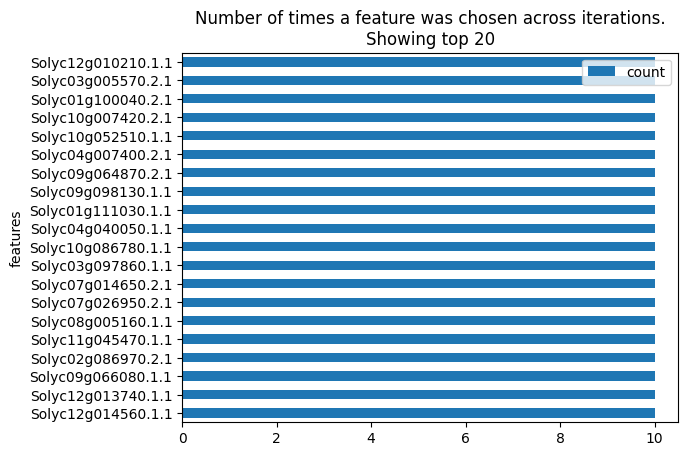

In [39]:
fig_path = './results/tomato-' + 'trg_' + target + '-' + model_name + '-feature-stability-count.png'

chosen_per_feature = dict((abs(results) >= selector.threshold_).astype(int).sum(axis=0))
chosen_per_feature = dict(sorted(chosen_per_feature.items(), key=lambda x:abs(x[1]), reverse=True))
chosen_per_feature = pd.DataFrame(chosen_per_feature, index=[0]).T.reset_index(names='features')
chosen_per_feature.columns = ['features','count']
chosen_per_feature.sort_values('count',inplace=True, ascending=False)
chosen_per_feature.iloc[:20,].plot.barh(y='count', x='features', title='Number of times a feature was chosen across iterations.\nShowing top 20').get_figure().savefig(fig_path)

We have 356 features that appeared all the time, 246 that appeared in 90% of the time, etc.:

In [40]:
counts = pd.DataFrame(np.unique(chosen_per_feature['count'], return_counts=True)).T
counts.columns = ['nr_of_times_in_the_model', 'nr_of_features']
# Save for inspection
counts.to_csv('./results/tomato-' + 'trg_' + target + '-' + model_name + '-iterations-count.csv', index=False)
counts

,nr_of_times_in_the_model,nr_of_features
0,0,21037
1,1,2849
2,2,1271
3,3,746
4,4,552
5,5,384
6,6,319
7,7,286
8,8,255
9,9,244


Let's see the intersect between the features that appeared all the time and the ones chosen on the full dataset:

In [41]:
chosen_features_full_model = list(features_coeff_fullmodel[features_coeff_fullmodel['chosen'] == True]['feature'])
print(f"There are {len(chosen_features_full_model)} chosen in the full model. ")

There are 2413 chosen in the full model. 


In [42]:
features_filtered = list(chosen_per_feature[chosen_per_feature['count'] == 10]['features'])
print(f'From {len(features_filtered)} chosen in all of the iterations, {len(set(chosen_features_full_model).intersection(features_filtered))} of them were chosen in the full model.')

From 355 chosen in all of the iterations, 355 of them were chosen in the full model.


### Overall stability score (Noguera)

In [43]:
# Transform the results matrix into binary - 0 = not selected, 1 = selected
results_binary = (abs(results) >= general_threshold).astype(int)
results_binary = np.asanyarray(results_binary)
results_binary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [44]:
stability_class = getStability(results_binary)
print(f"Overall stability score is {round(stability_class*100,2)}%")

Overall stability score is 46.07%
